# Imports

In [1]:
import torch
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage import io, transform
import matplotlib.pyplot as plt
import os
from os import listdir
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import cv2
import time
import fastprogress
from tqdm import tqdm

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Check GPU

In [2]:
num_cpus = os.cpu_count()
device = torch.device('cuda:0')
torch.cuda.get_device_name(device)

'Tesla P100-PCIE-16GB'

Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Data is stored in NEU_DET NEW folder

In [4]:
new_dir = '/content/drive/My Drive/NEU_DET NEW'

image_names = [f for f in listdir(new_dir)]
print(f'Total Number of Defects:\t{len(image_names)}')

Total Number of Defects:	1294


Create Defect types list

In [0]:
new_types = ['pitted_surface', 'rolled-in-scale', 'crazing', 'inclusion', 'patches', 'scratches']

def str_to_defect_types(s):
  defect_types = []
  for t in new_types:
    defect_types.append(s.count(t))

  return defect_types

Load data

In [0]:
## Warning! Takes a long time
img_data = []
img_type = []

for i,img in enumerate(image_names):
   img_data.append(np.array(io.imread(os.path.join(new_dir, img))))
   img_type.append(str_to_defect_types(img))


new_defects_df = pd.DataFrame({'img':img_data,'type':img_type})

Save to .npy files, because it takes a long time to read all images

In [0]:
img_data_np = np.array(img_data)
img_types_np = np.array(img_type)
img_data_file = os.path.join('/content/drive/My Drive/Defects', 'img_data_new.npy')
img_types = os.path.join('/content/drive/My Drive/Defects', 'img_types_new.npy')


np.save(img_data_file, img_data_np)
np.save(img_types, img_types_np)


Load from .npy files

In [8]:
img_dataa = list(np.load(img_data_file, allow_pickle=True)[()])
img_typee = list(np.load(img_types, allow_pickle=True)[()])

defects_df2 = pd.DataFrame({'img':img_dataa,'type':img_typee})
defects_df2.head()

,img,type
0,"[[[60, 60, 60], [57, 57, 57], [56, 56, 56], [5...","[0, 0, 0, 2, 2, 0]"
1,"[[[74, 74, 74], [73, 73, 73], [72, 72, 72], [7...","[0, 0, 1, 2, 1, 0]"
2,"[[[172, 172, 172], [163, 163, 163], [142, 142,...","[0, 0, 1, 1, 2, 0]"
3,"[[[88, 88, 88], [93, 93, 93], [88, 88, 88], [9...","[1, 0, 0, 2, 1, 0]"
4,"[[[108, 108, 108], [108, 108, 108], [108, 108,...","[0, 1, 0, 2, 1, 0]"


Class for Surface Defect Database

In [0]:
def type_decoder(defect_type):
    '''returns the literal string of the given numerical defect type'''
    if torch.is_tensor(defect_type):
            defect_type = defect_type.tolist()
    return types[defect_type]
    

class SurfaceDefectClassificationDataset(Dataset):
    '''Surface Defects Classification dataset.'''

    def __init__(self, df, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            image_dir (string): Directory with all the images
            transform (callable, optional): turn the objects into tensors
        """
        self.defects = df
        self.transform = transform

    def __len__(self):
        return len(self.defects)

    def __getitem__(self, idx):
        '''get one Item from the dataset'''
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        item = self.defects.iloc[idx]
        img = item['img']
        deftype = item['type']

        
        sample = {'img': img,'defect': deftype}

        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    '''Convert image, bounding box array and defect int  into Tensors.'''

    def __call__(self, sample):
        # Normalization
        image = np.array(sample['img'], dtype='float')/255
        
        # Standardization
        image = (image-MEAN)/STD
        def_type = np.array(sample['defect'])

        # rotating
        M = cv2.getRotationMatrix2D((200,200), angle=np.random.randint(0,4)*90, scale=1.0)
        image = cv2.warpAffine(image, M, (400, 400))
        
        my_tensor = torch.from_numpy(image).float().transpose(0,2)
        my_tensor = TF.to_pil_image(my_tensor)
        my_tensor = TF.resize(my_tensor, (100, 100), interpolation=2)
        my_tensor = TF.to_tensor(my_tensor)
        return [my_tensor,
                torch.from_numpy(def_type)]
              

Dataloaders to work with batches

In [10]:
batch_size = 42

# surDef_transforms = transforms.Compose([transforms.ToTensor()])
defects_dataset = SurfaceDefectClassificationDataset(df = defects_df2,
                                       transform=ToTensor())
train_size = int(0.8*len(defects_dataset))

train_data, test_data = torch.utils.data.random_split(defects_dataset, [train_size, len(defects_dataset)- train_size])

print(f'Length of the whole Dataset:\t{len(defects_dataset)}')

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_cpus // 1)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_cpus // 1)
print(f'Number of Batches (train|test):\t{len(train_dataloader)}|{len(test_dataloader)}') 

Length of the whole Dataset:	1294
Number of Batches (train|test):	25|7


Show a sample from dataset


Let us look at a random example of the dataset:


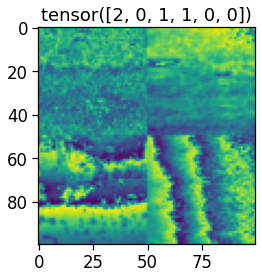

In [11]:
MEAN, STD = 0.49484, 0.18433

X, y = next(iter(train_dataloader))
print('\nLet us look at a random example of the dataset:')
plt.imshow(X[0,0])
plt.title(str(y[0]))
plt.show()

### VGG 16

In [0]:
vgg16 = torchvision.models.vgg16_bn(pretrained=True).cuda()
cross_entropy = nn.functional.cross_entropy
optimizer_vgg = torch.optim.Adam(vgg16.parameters(), lr=1e-4)
vgg_model_path = os.path.join('/content/drive/My Drive/Defects', 'model_vgg16_bn_10epochs.pt')

Model for multi-label classification

In [0]:
class VGG16_multilabel(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model = vgg16

        self.last_layer = nn.Linear(1000, 6)

        # self.features = pretrained_model.features
        
        # for p in self.features.parameters():
        #   p.requires_grad = False

    def forward(self, x):
        return self.last_layer(self.pretrained_model(x))

model = VGG16_multilabel()

In [14]:
model.to(device)

VGG16_multilabel(
  (pretrained_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, strid

Loss function and optimizer

In [0]:
loss = nn.MSELoss()
optimizer_vgg = torch.optim.Adam(model.parameters(), lr=1e-5)


Functions for training

In [0]:
train_loss, val_loss = [], []
def accuracy(correct, total): return float(correct)/total
    
def trainA(dataloader, optimizer, model, loss_fn, train_loss, master_bar, reg=False):
    model.train()
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for t, (x,y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        
        rounded = torch.round(y_pred).cuda()
        for i in range(len(y)):
          for j in range(6):
            epoch_total += 1
            if (y[i][j] == rounded[i][j]):
              epoch_correct += 1

        y = y.type(dtype=torch.float)
        loss_fn.requres_grad = True
        loss = loss_fn(y_pred, y)

        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        averaged_loss = sum(epoch_loss[-50:])/len(epoch_loss[-50:])
        
    train_loss.extend(epoch_loss)
    epoch_accuracy = accuracy(epoch_correct, epoch_total)
    
    return epoch_loss, epoch_accuracy

def validate(dataloader, model, loss_fn, val_loss, master_bar):
    model.eval()
    epoch_loss, epoch_misclassified = [], []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        x,y = x.to(device), y.to(device)
        y_pred = model(x)

        rounded = torch.round(y_pred).cuda()
        for i in range(len(y)):
          for j in range(6):
            epoch_total += 1
            if (y[i][j] == rounded[i][j]):
              epoch_correct += 1

        y = y.type(dtype=torch.float)
        loss_fn.requres_grad = True
        loss = loss_fn(y_pred, y)
        epoch_loss.append(loss.item())
        averaged_loss = sum(epoch_loss[-50:])/len(epoch_loss[-50:])

    epoch_accuracy = accuracy(epoch_correct, epoch_total)
    return epoch_loss, epoch_accuracy

def train(model, optimizer, num_epochs=10, loss_fn=nn.functional.cross_entropy, reg=False):
    master_bar = fastprogress.master_bar(range(num_epochs))
    plot_train_loss, plot_val_loss, train_acc, val_acc = [],[],[],[]
    for epoch in master_bar:
        epoch_train_loss, epoch_train_acc = trainA(train_dataloader, optimizer, model, loss_fn, train_loss, master_bar, reg)
        epoch_train_mean_loss = sum(epoch_train_loss)/len(epoch_train_loss)
        epoch_val_loss, epoch_val_acc = validate(test_dataloader, model, loss_fn, val_loss, master_bar)
        epoch_val_mean_loss = sum(epoch_val_loss)/len(epoch_val_loss)
        plot_train_loss.append(epoch_train_mean_loss), plot_val_loss.append(epoch_val_mean_loss), train_acc.append(epoch_train_acc), val_acc.append(epoch_val_acc)
        master_bar.write(f'Train loss: {epoch_train_mean_loss:.2f}, val loss: {epoch_val_mean_loss:.2f}, train acc: {epoch_train_acc:.2f}, val acc: {epoch_val_acc:.2f}')
        if (epoch_train_acc>0.99) & (epoch_val_acc>0.97):
            return{'tl':plot_train_loss,'vl':plot_val_loss,'ta':train_acc,'va':val_acc,'num_epochs':range(int(num_epochs))} 
    return{'tl':plot_train_loss,'vl':plot_val_loss,'ta':train_acc,'va':val_acc,'num_epochs':range(int(num_epochs))}

Start training

In [17]:
start_time = time.time() 

scores_vgg16 = train(model = model, optimizer = optimizer_vgg, loss_fn=loss, num_epochs = 42)

print("--- execution time in seconds : %s ---" % (time.time() - start_time))

--- execution time in seconds : 329.922714471817 ---


Plots for loss and accuracy per epoch

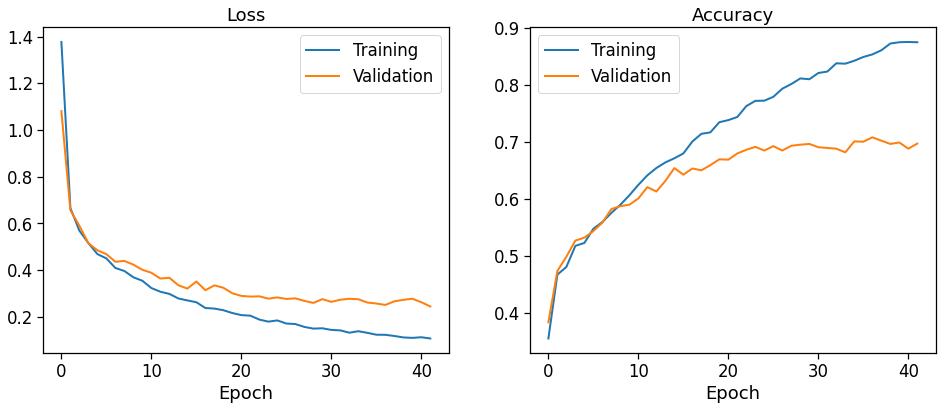

In [18]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title('Loss')
sns.lineplot(scores_vgg16['num_epochs'], scores_vgg16['tl'], ax=ax1, label='Training')
sns.lineplot(scores_vgg16['num_epochs'], scores_vgg16['vl'], ax=ax1, label='Validation')
ax1.set_xlabel('Epoch')
ax1.legend()
ax2.set_title('Accuracy')
sns.lineplot(scores_vgg16['num_epochs'], scores_vgg16['ta'], ax=ax2, label='Training') 
sns.lineplot(scores_vgg16['num_epochs'], scores_vgg16['va'], ax=ax2, label='Validation') 
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

Save model

In [0]:
vgg_model_path = os.path.join('/content/drive/My Drive/Defects', 'model_vgg16_multilabel_may_1.pt')
torch.save(model.state_dict(), vgg_model_path)

Load model

In [0]:
vgg_model_path = os.path.join('/content/drive/My Drive/Defects', 'model_vgg16_multilabel_may_1.pt')
model.load_state_dict(torch.load(vgg_model_path))
model.to(device)
model.eval();

### Inference


Random example from the dataset:


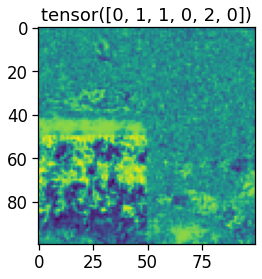

In [21]:
X, y = next(iter(test_dataloader))
print('\nRandom example from the dataset:')
plt.imshow(X[0,0])
plt.title(str(y[0]))
plt.show()

Predict the classes for loaded sample

In [22]:
model.eval()
sample = X.to(device)

start_time = time.time() 

y_pred = model(sample)

print("--- execution time in seconds : %s ---" % (time.time() - start_time))


--- execution time in seconds : 0.0051457881927490234 ---


In [23]:
y = y.cuda()
rounded = torch.round(y_pred).cuda().int()
print('Original label: ', y[0].cpu().numpy())
print('Predicted label: ', y_pred[0].cpu().detach().numpy())
print('Final rounded label: ', rounded[0].cpu().numpy())

Original label:  [0 1 1 0 2 0]
Predicted label:  [ 0.23837084  0.93727416  1.1202269  -0.07950372  1.4097947   0.07644065]
Final rounded label:  [0 1 1 0 1 0]


# Data augmentation using rotation 
The code for testing different settings is the same

In [0]:
## Warning! Takes a long time
img_data = []
img_type = []

for i,img in enumerate(image_names):
   img_data.append(np.array(io.imread(os.path.join(new_dir, img), as_gray=True)))
   img_type.append(str_to_defect_types(img))
   
new_defects_df = pd.DataFrame({'img':img_data,'type':img_type})

In [0]:
def rotations(df,angles):
    len_df = len(df)
    for ix in range(len_df):
        img = df['img'][ix]
        def_type = df['type'][ix]
        (h, w) = img.shape
        center = (w / 2, h / 2)
        scale = 1.0
        for angle in angles:
            M = cv2.getRotationMatrix2D(center, angle, scale)
            rotated = cv2.warpAffine(img, M, (h, w))
            rot_image = {'img':rotated, 'type':def_type}
            df = df.append(rot_image, ignore_index=True)
    return df
  
def data_augmentation(df, angles):
    df = rotations(df,angles)
    return df

New dataset with rotated images

In [0]:
defects_aug = data_augmentation(new_defects_df, angles=[90,180,270])

In [0]:
def type_decoder(defect_type):
    '''returns the literal string of the given numerical defect type'''
    if torch.is_tensor(defect_type):
            defect_type = defect_type.tolist()
    return types[defect_type]
    

class SurfaceDefectClassificationDataset(Dataset):
    '''Surface Defects Classification dataset.'''

    def __init__(self, df, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            image_dir (string): Directory with all the images
            transform (callable, optional): turn the objects into tensors
        """
        self.defects = df
        self.transform = transform

    def __len__(self):
        return len(self.defects)

    def __getitem__(self, idx):
        '''get one Item from the dataset'''
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        item = self.defects.iloc[idx]
        img = item['img']
        deftype = item['type']

        
        sample = {'img': img,'defect': deftype}

        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    '''Convert image, bounding box array and defect int  into Tensors.'''

    def __call__(self, sample):
        image = sample['img']

        # Standardization
        image = (image-MEAN)/STD
        def_type = np.array(sample['defect'])

        # rotating
        M = cv2.getRotationMatrix2D((200,200), angle=np.random.randint(0,4)*90, scale=1.0)
        image = cv2.warpAffine(image, M, (400, 400))
        
        
        my_tensor = torch.from_numpy(image).unsqueeze(dim=0).float().expand(3,400,400)
        my_tensor = TF.to_pil_image(my_tensor)
        my_tensor = TF.resize(my_tensor, (100, 100), interpolation=2)
        my_tensor = TF.to_tensor(my_tensor)

        return [my_tensor,
                torch.from_numpy(def_type)]
              

Redefine dataloaders

In [31]:
batch_size = 42

# surDef_transforms = transforms.Compose([transforms.ToTensor()])
defects_dataset = SurfaceDefectClassificationDataset(df = defects_aug,
                                       transform=ToTensor())
train_size = int(0.8*len(defects_dataset))

train_data, test_data = torch.utils.data.random_split(defects_dataset, [train_size, len(defects_dataset)- train_size])

print(f'Length of the whole Dataset:\t{len(defects_dataset)}')

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_cpus // 1)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_cpus // 1)
print(f'Number of Batches (train|test):\t{len(train_dataloader)}|{len(test_dataloader)}') 

Length of the whole Dataset:	5176
Number of Batches (train|test):	99|25



Let us look at a random example of the dataset:


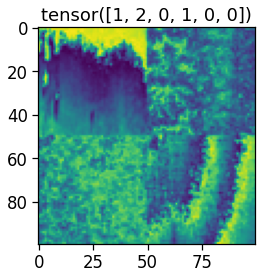

In [32]:
MEAN, STD = 0.49484, 0.18433

X, y = next(iter(train_dataloader))
print('\nLet us look at a random example of the dataset:')
plt.imshow(X[0,0])
plt.title(str(y[0]))
plt.show()

# VGG 16

In [0]:
vgg16 = torchvision.models.vgg16_bn(pretrained=True).cuda()
model_aug = VGG16_multilabel()
model_aug.to(device);

In [0]:
loss = nn.MSELoss()
optimizer_vgg = torch.optim.Adam(model_aug.parameters(), lr=1e-5)

In [36]:
start_time = time.time() 

scores_vgg16 = train(model = model_aug, optimizer = optimizer_vgg, loss_fn=loss, num_epochs = 42)

print("--- execution time in seconds : %s ---" % (time.time() - start_time))

--- execution time in seconds : 842.9334914684296 ---


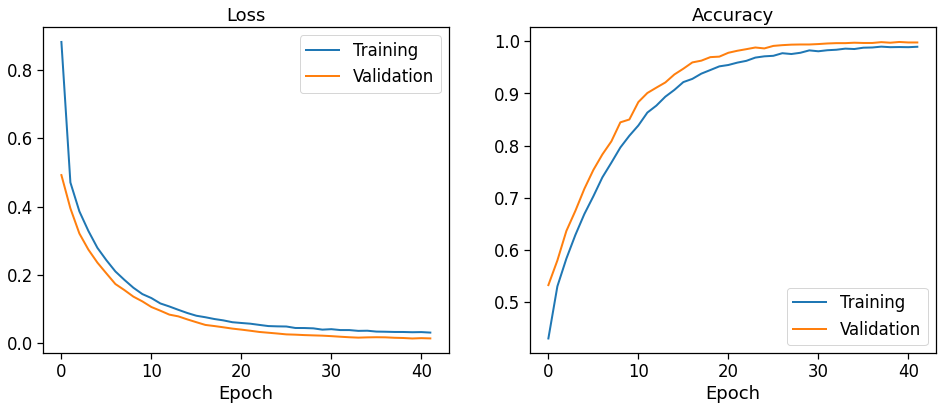

In [37]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title('Loss')
sns.lineplot(scores_vgg16['num_epochs'], scores_vgg16['tl'], ax=ax1, label='Training')
sns.lineplot(scores_vgg16['num_epochs'], scores_vgg16['vl'], ax=ax1, label='Validation')
ax1.set_xlabel('Epoch')
ax1.legend()
ax2.set_title('Accuracy')
sns.lineplot(scores_vgg16['num_epochs'], scores_vgg16['ta'], ax=ax2, label='Training') 
sns.lineplot(scores_vgg16['num_epochs'], scores_vgg16['va'], ax=ax2, label='Validation') 
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

# VGG 11

In [0]:
vgg11 = torchvision.models.vgg11_bn(pretrained=True).cuda()

In [0]:
class VGG11_multilabel(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model = vgg11

        self.last_layer = nn.Linear(1000, 6)

        # self.features = pretrained_model.features
        
        # for p in self.features.parameters():
        #   p.requires_grad = False

    def forward(self, x):
        return self.last_layer(self.pretrained_model(x))

In [0]:
model_aug_11 = VGG11_multilabel()
model_aug_11.to(device);

In [0]:
optimizer_vgg = torch.optim.Adam(model_aug_11.parameters(), lr=1e-5)

In [42]:
start_time = time.time() 

scores_vgg11 = train(model = model_aug_11, optimizer = optimizer_vgg, loss_fn=loss, num_epochs = 42)

print("--- execution time in seconds : %s ---" % (time.time() - start_time))

--- execution time in seconds : 778.3363609313965 ---


Function for saving plots

In [0]:
file_name = '/content/drive/My Drive/Defects/plot2.png'
def plot_loss_acc(scores,file_name):
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,3))
    ax1.set_title('Loss', fontweight="bold")
    sns.lineplot(range(len(scores['tl'])), scores['tl'], ax=ax1, label='Training')
    sns.lineplot(range(len(scores['tl'])), scores['vl'], ax=ax1, label='Validation')
    ax1.get_legend().remove()
    ax2.set_title('Accuracy', fontweight="bold")
    sns.lineplot(range(len(scores['tl'])), scores['ta'], ax=ax2, label='Training') 
    sns.lineplot(range(len(scores['tl'])), scores['va'], ax=ax2, label='Validation') 
    handles, labels = ax2.get_legend_handles_labels()
    ax2.get_legend().remove()
    fig.legend(handles, labels, loc='center right', 
               borderaxespad=0.1, framealpha=1)
    #plt.savefig(file_name, bbox_inches='tight')
    plt.show()

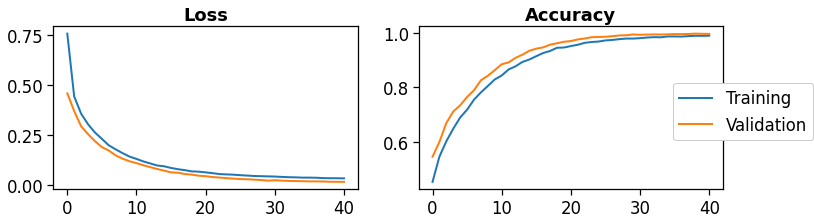

In [48]:
plot_loss_acc(scores_vgg11, file_name)

# VGG 11 with frozen weights

In [0]:
vgg11 = torchvision.models.vgg11_bn(pretrained=True).cuda()

In [0]:
class VGG11_multilabel_frozen(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model = vgg11

        self.last_layer = nn.Linear(1000, 6)

     
        for p in self.pretrained_model.features.parameters():
          p.requires_grad = False

    def forward(self, x):
        return self.last_layer(self.pretrained_model(x))

In [0]:
model_aug_11_frozen = VGG11_multilabel_frozen()
model_aug_11_frozen.to(device);
optimizer_vgg = torch.optim.Adam(model_aug_11_frozen.parameters(), lr=1e-5)

In [56]:
start_time = time.time() 

scores_vgg11 = train(model = model_aug_11_frozen, optimizer = optimizer_vgg, loss_fn=loss, num_epochs = 42)

print("--- execution time in seconds : %s ---" % (time.time() - start_time))

--- execution time in seconds : 761.8507685661316 ---


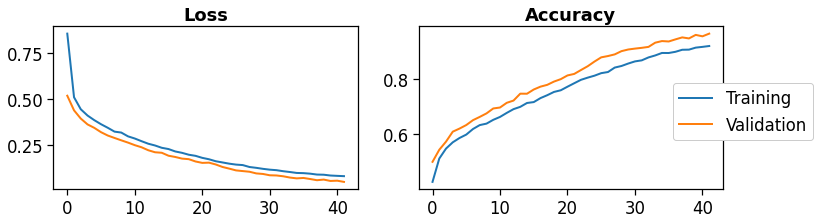

In [59]:
plot_loss_acc(scores_vgg11, file_name)